In [15]:
import torch
from torch import nn, optim
import tqdm
import os
import tifffile as tiff
import numpy as np
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms
import random
from torch.utils.data import random_split
import matplotlib.pyplot as plt

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
set_seed(42)

In [16]:
# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir,size):
        self.image_dir = image_dir
        #self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]
        #we don't need to resize into 96*96 because we are doing that in below contrastive transform (self.resize_transform = transforms.resize((96,96)))
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(size=size),
            transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(kernel_size=9),
            #transforms.Normalize(mean=mean, std=std) #Dataset specific normalisation
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) #When you are using pre-trained models that expect inputs normalized with specific values.
        ])
    
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        # Convert to a torch tensor
        image = torch.tensor(image, dtype=torch.float32)
        
        if self.transform:
            image1 = self.transform(image)
            image2 = self.transform(image)
        return image1, image2

In [17]:
def plot_curves(train_losses, val_losses, train_top1_accs, val_top1_accs, train_top5_accs, val_top5_accs, train_mean_pos, val_mean_pos):
    epochs = range(1, len(train_losses) + 1)

    # Plot loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Top-1 accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_top1_accs, 'bo-', label='Training Top-1 Accuracy')
    plt.plot(epochs, val_top1_accs, 'ro-', label='Validation Top-1 Accuracy')
    plt.title('Training and Validation Top-1 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-1 Accuracy (%)')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

    # Plot Top-5 accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train_top5_accs, 'bo-', label='Training Top-5 Accuracy')
    plt.plot(epochs, val_top5_accs, 'ro-', label='Validation Top-5 Accuracy')
    plt.title('Training and Validation Top-5 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-5 Accuracy (%)')
    plt.legend()

    # Plot Mean Position of Positive Example
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train_mean_pos, 'bo-', label='Training Mean Position')
    plt.plot(epochs, val_mean_pos, 'ro-', label='Validation Mean Position')
    plt.title('Training and Validation Mean Position of Positive Example')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Position')
    plt.legend()

    plt.tight_layout()
    plt.show()



# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])
#

In [18]:
class Resnet(nn.Module):
    def __init__(self, hidden_dim):
        super(Resnet, self).__init__()
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')

        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

    def forward(self, x):
        return self.convnet(x)
    

#print(Resnet(96))

In [19]:
def SimCLR_loss(feats, temperature):
    # Calculate cosine similarity
    cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
    # Mask out cosine similarity to itself
    self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
    cos_sim.masked_fill_(self_mask, -9e15)
    
    # Find positive example -> batch_size//2 away from the original example
    pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
    # InfoNCE loss
    cos_sim = cos_sim / temperature
    nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
    nll = nll.mean()

    # Accuracy calculations
    comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # First position positive example
                          cos_sim.masked_fill(pos_mask, -9e15)],
                         dim=-1)
    sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)

    # Calculate accuracy metrics
    acc_top1 = (sim_argsort == 0).float().mean()
    acc_top5 = (sim_argsort < 5).float().mean()
    mean_pos = 1 + sim_argsort.float().mean()

    return nll, acc_top1.item(), acc_top5.item(), mean_pos.item()

In [20]:
def train(train_loader, model, epochs, lr=5e-4, temperature=0.07, weight_decay=1e-4, device='cuda', validate=False):
    if not validate:
        model = model.train().to(device)
    else:
        model = model.eval().to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=lr / 50)

    train_losses = []
    train_top1_accs = []
    train_top5_accs = []
    mean_positions = []

    for epoch in range(epochs):
        total_loss = 0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for imgs1, imgs2 in train_loader:
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)
            imgs = torch.cat((imgs1, imgs2), dim=0)
            feats = model(imgs)

            # Compute the loss and accuracy
            loss, acc_top1, acc_top5, mean_pos = SimCLR_loss(feats, temperature)

            if not validate:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                lr_scheduler.step()

            total_loss += loss.item()
            total_top1_acc += acc_top1
            total_top5_acc += acc_top5
            total_mean_pos += mean_pos

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        train_losses.append(avg_loss)
        train_top1_accs.append(avg_top1_acc)
        train_top5_accs.append(avg_top5_acc)
        mean_positions.append(avg_mean_pos)

        print(f"Epoch {epoch + 1}/{epochs} | "
              f"Loss: {avg_loss:.4f} | "
              f"Top-1 Acc: {avg_top1_acc:.2f}% | "
              f"Top-5 Acc: {avg_top5_acc:.2f}% | "
              f"Mean Position: {avg_mean_pos:.2f}")

    return model, (train_losses, train_top1_accs, train_top5_accs, mean_positions)


Batch 0:
  Image1: torch.Size([16, 3, 96, 96])
  Image2: torch.Size([16, 3, 96, 96])
Resnet(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=F

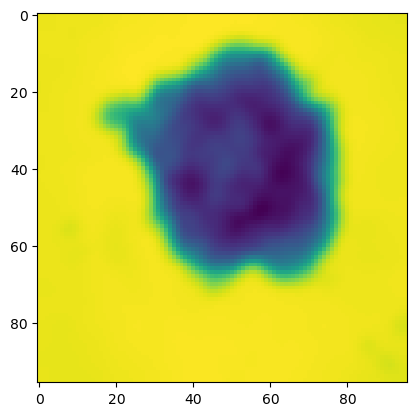

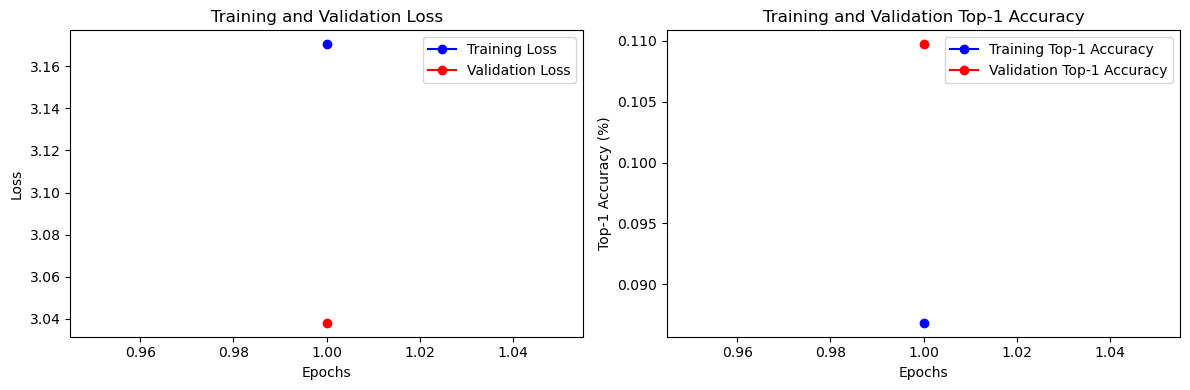

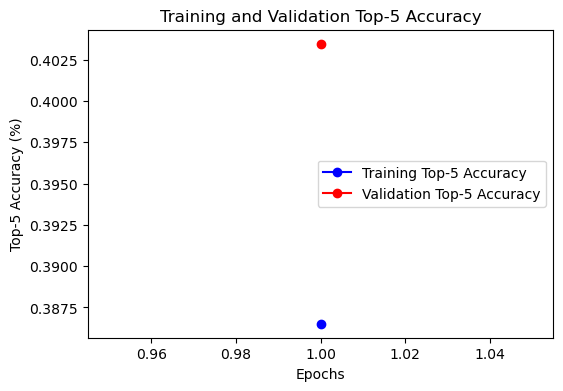

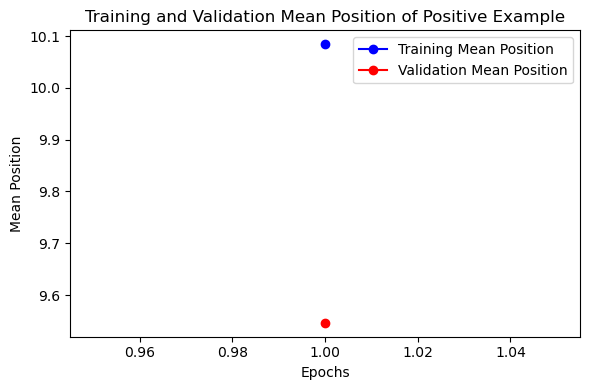

In [21]:
batch_size = 16
size = 96

image_dir = r"../../tiff_experiment_unsupervised_data/combined"
dataset = ImageDataset(image_dir=image_dir,size=size)


# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, 
                          drop_last=False, 
                          pin_memory=True, 
                          num_workers=0) #num_workers=os.cpu count() using cluster gpu
val_loader = DataLoader(val_dataset, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        drop_last=False, 
                        pin_memory=True, 
                        num_workers=0)

for i, (image1, image2) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(f"  Image1: {image1.shape}")
    print(f"  Image2: {image2.shape}")
    plt.imshow(image1[0,0])
    break

model = Resnet(size)
print(model)
print('training')
model, train_results = train(train_loader, model, epochs=1, device='cuda')
print('validating')
model, val_results = train(val_loader, model, epochs=1, device='cuda', validate=True)

train_losses, train_top1_accs, train_top5_accs, train_mean_pos = train_results
val_losses, val_top1_accs, val_top5_accs, val_mean_pos = val_results

plot_curves(train_losses, val_losses, train_top1_accs, val_top1_accs, train_top5_accs, val_top5_accs, train_mean_pos, val_mean_pos)